<a href="https://colab.research.google.com/github/kairamilanifitria/HPVD/blob/main/HPVD_FIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stage 1 : MS Marco Dataset

In [1]:
!pip install -q datasets rank_bm25 sentence-transformers ir-measures pytrec_eval faiss-cpu tqdm
import sys
import os
import math
from pprint import pprint

from google.colab import drive
drive.mount('/content/drive')

save_dir = "/content/drive/MyDrive/HPVD_FIX"
os.makedirs(save_dir, exist_ok=True)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.8/304.8 kB 19.3 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
from datasets import load_dataset
import pandas as pd

# Load MS MARCO passage dev set (v1.1)
ms_marco = load_dataset("ms_marco", "v1.1", split="validation")

# Print dataset size
print("Total dev set size:", len(ms_marco))

# Extract fields into lists
query_ids = []
queries = []
passages_list = []
passage_ids_list = []
answers_list = []

for idx, example in enumerate(ms_marco):
    query_ids.append(idx)
    queries.append(example["query"])

    # passages object contains: passage_text, is_selected, url
    passage_texts = example["passages"]["passage_text"]

    passages_list.append(example["passages"])  # keep full structure if needed

    # Correct passage IDs (0..N-1)
    passage_ids_list.append(list(range(len(passage_texts))))

    answers_list.append(example["answers"])

# Convert to DataFrame for inspection
df = pd.DataFrame({
    "query_id": query_ids,
    "query": queries,
    "passages": passages_list,
    "passage_ids": passage_ids_list,
    "answers": answers_list
})

print("Created dataframe with rows:", len(df))

df.head()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

v1.1/validation-00000-of-00001.parquet:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

v1.1/train-00000-of-00001.parquet:   0%|          | 0.00/175M [00:00<?, ?B/s]

v1.1/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10047 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/82326 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9650 [00:00<?, ? examples/s]

Total dev set size: 10047
Created dataframe with rows: 10047


,query_id,query,passages,passage_ids,answers
0,0,walgreens store sales average,"{'is_selected': [1, 0, 0, 0, 0, 0], 'passage_t...","[0, 1, 2, 3, 4, 5]","[Approximately $15,000 per year.]"
1,1,how much do bartenders make,"{'is_selected': [0, 1, 0, 0, 0, 0, 0, 0], 'pas...","[0, 1, 2, 3, 4, 5, 6, 7]","[$21,550 per year, The average hourly wage for..."
2,2,what is a furuncle boil,"{'is_selected': [0, 0, 0, 0, 0, 0, 1, 0], 'pas...","[0, 1, 2, 3, 4, 5, 6, 7]","[A boil, also called a furuncle, is a deep fol..."
3,3,what can urinalysis detect,"{'is_selected': [0, 0, 0, 0, 1, 0, 0, 0, 0], '...","[0, 1, 2, 3, 4, 5, 6, 7, 8]","[Detect and assess a wide range of disorders, ..."
4,4,what is vitamin a used for,"{'is_selected': [0, 0, 0, 0, 1, 0, 0, 0, 0], '...","[0, 1, 2, 3, 4, 5, 6, 7, 8]","[Shigellosis, diseases of the nervous system, ..."


# Stage 2 : Sparse and Dense Retriever

Sparse : BM25

In [3]:
from rank_bm25 import BM25Okapi
import numpy as np

class SparseRetriever:
    def __init__(self, documents):
        self.documents = documents
        self.tokenized_docs = [doc.lower().split() for doc in documents]
        self.bm25 = BM25Okapi(self.tokenized_docs)

    def search(self, query, top_k=10):
        tokenized_query = query.lower().split()
        scores = self.bm25.get_scores(tokenized_query)
        top_indices = np.argsort(scores)[::-1][:top_k]
        return [(int(idx), float(scores[idx])) for idx in top_indices]


# Step 1 — Flatten all passages
all_passages = []
global_to_qid_pid = {}  # map global passage index -> (query_id, passage_id)

global_idx = 0

for i, row in df.iterrows():
    qid = row["query_id"]
    passage_texts = row["passages"]["passage_text"]   # FIXED
    passage_ids = row["passage_ids"]                  # [0..N-1]

    for pid, text in zip(passage_ids, passage_texts):
        all_passages.append(text)
        global_to_qid_pid[global_idx] = (qid, pid)
        global_idx += 1

print("Total passages in corpus:", len(all_passages))
print("Example entry:", list(global_to_qid_pid.items())[:5])


Total passages in corpus: 82360
Example entry: [(0, (0, 0)), (1, (0, 1)), (2, (0, 2)), (3, (0, 3)), (4, (0, 4))]


In [4]:
bm25_retriever = SparseRetriever(all_passages)

# Test retrieval
test_row_index = 0
test_query = df.loc[test_row_index, "query"]
test_qid = df.loc[test_row_index, "query_id"]  # <-- FIXED

results = bm25_retriever.search(test_query, top_k=5)
print("Query:", test_query)
print("Top 5 results:", results)


print("\n=== BM25 RESULTS WITH CORRECT RELEVANCE CHECK ===")

# Ground-truth relevance ONLY for this query
test_is_selected = df.loc[int(test_qid)]["passages"]["is_selected"]

for rank, (global_idx, score) in enumerate(results, start=1):
    qid, pid = global_to_qid_pid[global_idx]  # map to (query_id, passage_id)

    if qid == test_qid:
        # Check relevance for THIS query only
        relevance = test_is_selected[pid]
        status = "✔ relevant" if relevance == 1 else "✘ not relevant"
    else:
        status = "— (belongs to another query)"

    print(f"Rank {rank}: global {global_idx} -> (qid={qid}, pid={pid}) | {status}")


Query: walgreens store sales average
Top 5 results: [(5, 27.175714831240484), (2, 23.066096611756286), (3, 22.578487000751764), (12059, 19.51484875136343), (0, 18.326614418617375)]

=== BM25 RESULTS WITH CORRECT RELEVANCE CHECK ===
Rank 1: global 5 -> (qid=0, pid=5) | ✘ not relevant
Rank 2: global 2 -> (qid=0, pid=2) | ✘ not relevant
Rank 3: global 3 -> (qid=0, pid=3) | ✘ not relevant
Rank 4: global 12059 -> (qid=1470, pid=4) | — (belongs to another query)
Rank 5: global 0 -> (qid=0, pid=0) | ✔ relevant


In [5]:
from tqdm import tqdm

run_bm25 = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    qid = row["query_id"]
    query = row["query"]

    top_results = bm25_retriever.search(query, top_k=10)

    for rank, (global_idx, score) in enumerate(top_results):
        mapped_qid, mapped_pid = global_to_qid_pid[global_idx]
        run_bm25.append({
            "query_id": mapped_qid,
            "doc_id": mapped_pid,
            "score": score,
            "rank": rank + 1
        })

100%|██████████| 10047/10047 [42:10<00:00,  3.97it/s]


In [6]:
qrels = {}

for i, row in df.iterrows():
    qid = str(row["query_id"])   # convert to string
    is_selected = row["passages"]["is_selected"]
    passage_ids = [str(pid) for pid in row["passage_ids"]]

    qrels[qid] = {pid: rel for pid, rel in zip(passage_ids, is_selected)}

from ir_measures import ScoredDoc, Qrel, nDCG, Recall
import ir_measures

run_bm25_objs = [
    ScoredDoc(
        query_id=str(entry["query_id"]),
        doc_id=str(entry["doc_id"]),
        score=float(entry["score"])
    )
    for entry in run_bm25
]

qrels_objs = [
    ir_measures.Qrel(
        query_id=str(qid),
        doc_id=str(pid),
        relevance=int(rel)
    )
    for qid, doc_dict in qrels.items()
    for pid, rel in doc_dict.items()
]

metrics = [nDCG@10, Recall@50]
scores = ir_measures.calc_aggregate(metrics, qrels_objs, run_bm25_objs)

print("BM25 baseline:", scores)


BM25 baseline: {nDCG@10: 0.4577205461437541, R@50: 0.7405859128761488}


dense : qwen embedding

In [13]:
NEBIUS_API_KEY = "v1.CmQKHHN0YXRpY2tleS1lMDBwaDh0MjR3bWZxczMwcGcSIXNlcnZpY2VhY2NvdW50LWUwMHo5MWIydHBnNHRkdGs1MjIMCJfB-8gGEIn39-0BOgwIlsSTlAcQwObxvANAAloDZTAw.AAAAAAAAAAGL36esdS7gxmfzpoTFtAPSQWy1uUx-178zHm0fWVCa6MRxuftWDbWogTgVHSUKhPlpq_3nOIZn3Yr2001ecGgC"

In [14]:
import os
import numpy as np
import faiss
from tqdm import tqdm
from openai import OpenAI

# Redefine DenseRetriever class to directly use the API key
class DenseRetriever:
    def __init__(self, documents=None, batch_size=32,
                 embeddings=None, index=None):
        """
        Two modes:
        1️⃣ Train mode: documents provided → embeddings computed
        2️⃣ Load mode: embeddings + FAISS index provided → no API calls
        """

        self.batch_size = batch_size

        # Initialize Nebius client safely, using the direct API key
        self.client = OpenAI(
            base_url="https://api.tokenfactory.nebius.com/v1/",
            api_key=NEBIUS_API_KEY # FIXED: Directly use the API key value
        )

        # LOAD MODE
        if embeddings is not None and index is not None:
            self.documents = documents
            self.doc_embeddings = embeddings
            self.index = index
            return

        # TRAIN MODE
        self.documents = documents

        print(f"Encoding {len(documents)} documents with Qwen3-Embedding-8B...")

        self.doc_embeddings = self.encode_documents(documents)
        faiss.normalize_L2(self.doc_embeddings)

        dim = self.doc_embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dim)
        self.index.add(self.doc_embeddings)

    def embed(self, texts):
        response = self.client.embeddings.create(
            model="Qwen/Qwen3-Embedding-8B",
            input=texts
        )
        return np.array([item.embedding for item in response.data], dtype="float32")

    def encode_documents(self, documents):
        vectors = []
        for i in tqdm(range(0, len(documents), self.batch_size)):
            batch = documents[i:i+self.batch_size]
            emb = self.embed(batch)
            vectors.append(emb)
        return np.vstack(vectors)

    def search(self, query, top_k=10):
        q_emb = self.embed([query]).astype("float32")
        faiss.normalize_L2(q_emb)
        scores, idx = self.index.search(q_emb, top_k)
        return [(int(idx[0][i]), float(scores[0][i])) for i in range(top_k)]

dense_retriever = DenseRetriever(documents=all_passages)


Encoding 82360 documents with Qwen3-Embedding-8B...


100%|██████████| 2574/2574 [56:00<00:00,  1.31s/it]


In [15]:
test_query = df.loc[0, "query"]
results_dense = dense_retriever.search(test_query, top_k=5)

print("Query:", test_query)
print("Top 5 Dense results:", results_dense)

Query: walgreens store sales average
Top 5 Dense results: [(4, 0.739250898361206), (2, 0.7124283313751221), (3, 0.6823194026947021), (0, 0.6538678407669067), (6463, 0.5948448181152344)]


In [16]:
from tqdm import tqdm

run_dense = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    qid = str(row["query_id"])
    query = row["query"]

    top_results = dense_retriever.search(query, top_k=10)

    for rank, (global_idx, score) in enumerate(top_results):
        mapped_qid, mapped_pid = global_to_qid_pid[global_idx]

        run_dense.append({
            "query_id": str(mapped_qid),
            "doc_id": str(mapped_pid),
            "score": float(score)
        })


100%|██████████| 10047/10047 [2:08:07<00:00,  1.31it/s]


In [17]:
from ir_measures import ScoredDoc, Qrel, nDCG, Recall
import ir_measures

# Convert run
run_dense_objs = [
    ScoredDoc(
        query_id=str(entry["query_id"]),
        doc_id=str(entry["doc_id"]),
        score=float(entry["score"])
    )
    for entry in run_dense
]

# Convert qrels
qrels_objs = [
    Qrel(query_id=str(qid), doc_id=str(pid), relevance=int(rel))
    for qid, doc_dict in qrels.items()
    for pid, rel in doc_dict.items()
]

# Compute metrics
metrics = [nDCG@10, Recall@50]
dense_scores = ir_measures.calc_aggregate(metrics, qrels_objs, run_dense_objs)

print("Dense baseline metrics (Qwen3-Embedding-8B):", dense_scores)

Dense baseline metrics (Qwen3-Embedding-8B): {nDCG@10: 0.5902578865809402, R@50: 0.9101058359045817}


hybrid

In [18]:
from tqdm import tqdm
import numpy as np

query_texts = df["query"].tolist()
query_ids = df["query_id"].tolist()

query_embeddings = []

for q in tqdm(query_texts, desc="Embedding queries with Qwen"):
    response = dense_retriever.client.embeddings.create(
        model="Qwen/Qwen3-Embedding-8B",
        input=q
    )
    emb = np.array(response.data[0].embedding, dtype="float32")
    query_embeddings.append(emb)

# Convert to matrix
query_embeddings = np.vstack(query_embeddings)

# Normalize for cosine similarity
faiss.normalize_L2(query_embeddings)


Embedding queries with Qwen: 100%|██████████| 10047/10047 [1:08:37<00:00,  2.44it/s]


In [19]:
from tqdm import tqdm

# Run FAISS batch search for all queries at once
scores, idxs = dense_retriever.index.search(query_embeddings, 50)

dense_cache = {}

print("Building dense_cache...")
for i, qid in tqdm(enumerate(query_ids), total=len(query_ids)):
    dense_cache[qid] = list(zip(idxs[i].tolist(), scores[i].tolist()))

Building dense_cache...


100%|██████████| 10047/10047 [00:00<00:00, 41056.29it/s]


In [20]:
bm25_cache = {}

for i, row in df.iterrows():
    qid = row["query_id"]
    query = row["query"]
    results = bm25_retriever.search(query, top_k=50)
    bm25_cache[qid] = results


In [21]:
from ir_measures import ScoredDoc, Qrel, nDCG, Recall

def compute_hybrid(alpha=0.5, epsilon=1e-8):
    run_hybrid = []

    for i, row in df.iterrows():
        qid = int(row["query_id"])

        top_bm25 = bm25_cache[qid]
        top_dense = dense_cache[qid]

        # Extract + normalize scores
        bm25_scores = np.array([s for _, s in top_bm25])
        dense_scores = np.array([s for _, s in top_dense])

        bm25_norm = (bm25_scores - bm25_scores.min()) / (bm25_scores.max() - bm25_scores.min() + epsilon)
        dense_norm = (dense_scores - dense_scores.min()) / (dense_scores.max() - dense_scores.min() + epsilon)

        # Convert to dict
        bm25_dict = {idx: score for (idx, _), score in zip(top_bm25, bm25_norm)}
        dense_dict = {idx: score for (idx, _), score in zip(top_dense, dense_norm)}

        # Merge both rankings
        all_indices = set(bm25_dict) | set(dense_dict)

        for idx in all_indices:
            score = alpha * bm25_dict.get(idx, 0) + (1 - alpha) * dense_dict.get(idx, 0)

            qid_mapped, pid_mapped = global_to_qid_pid[idx]

            run_hybrid.append(
                ScoredDoc(
                    query_id=str(qid_mapped),    # STRING
                    doc_id=str(pid_mapped),      # STRING
                    score=score
                )
            )

    # Build qrels objects (already string)
    qrels_objs = [
        Qrel(query_id=qid, doc_id=pid, relevance=rel)
        for qid, doc_dict in qrels.items()
        for pid, rel in doc_dict.items()
    ]

    return ir_measures.calc_aggregate([nDCG@10, Recall@50], qrels_objs, run_hybrid)


In [22]:
for a in [0.1, 0.3, 0.5, 0.7, 0.9]:
    s = compute_hybrid(alpha=a)
    print(f"Alpha {a}: nDCG@10 = {s[nDCG@10]:.4f} | Recall@50 = {s[Recall@50]:.4f}")


Alpha 0.1: nDCG@10 = 0.5096 | Recall@50 = 0.9661
Alpha 0.3: nDCG@10 = 0.5102 | Recall@50 = 0.9661
Alpha 0.5: nDCG@10 = 0.5086 | Recall@50 = 0.9661
Alpha 0.7: nDCG@10 = 0.5087 | Recall@50 = 0.9661
Alpha 0.9: nDCG@10 = 0.5066 | Recall@50 = 0.9661


save and load again

In [26]:
import pickle
import numpy as np
import faiss
import os

save_dir = "/content/drive/MyDrive/HPVD_FIX"
os.makedirs(save_dir, exist_ok=True)

# 1. Save BM25 retriever (safe)
with open(f"{save_dir}/bm25.pkl", "wb") as f:
    pickle.dump(bm25_retriever, f)

# 2. Save dense embeddings
np.save(f"{save_dir}/dense_embeddings.npy", dense_retriever.doc_embeddings)

# 3. Save FAISS index
faiss.write_index(dense_retriever.index, f"{save_dir}/dense_index.faiss")

# 4. Save metadata (documents, batch_size, etc.)
with open(f"{save_dir}/dense_meta.pkl", "wb") as f:
    pickle.dump({
        "documents": dense_retriever.documents,
        "batch_size": dense_retriever.batch_size,
    }, f)

# 5. Save dataset components
with open(f"{save_dir}/df.pkl", "wb") as f: pickle.dump(df, f)
with open(f"{save_dir}/global_to_qid_pid.pkl", "wb") as f: pickle.dump(global_to_qid_pid, f)
with open(f"{save_dir}/qrels.pkl", "wb") as f: pickle.dump(qrels, f)

# 6. Save caches (recommended)
with open(f"{save_dir}/bm25_cache.pkl", "wb") as f: pickle.dump(bm25_cache, f)
with open(f"{save_dir}/dense_cache.pkl", "wb") as f: pickle.dump(dense_cache, f)

print("✅ All retrieval objects saved safely.")


✅ All retrieval objects saved safely.


In [28]:
!pip install -q datasets rank_bm25 sentence-transformers ir-measures pytrec_eval faiss-cpu tqdm

In [29]:
load_dir = "/content/drive/MyDrive/HPVD_FIX" # FIXED: Changed to HPVD to match save location

# 1. Load BM25 retriever
with open(f"{load_dir}/bm25.pkl", "rb") as f:
    bm25_retriever = pickle.load(f)

# 2. Load embeddings
doc_embeddings = np.load(f"{load_dir}/dense_embeddings.npy")

# 3. Load FAISS index
faiss_index = faiss.read_index(f"{load_dir}/dense_index.faiss")

# 4. Load metadata
with open(f"{load_dir}/dense_meta.pkl", "rb") as f:
    meta = pickle.load(f)

documents = meta["documents"]
batch_size = meta["batch_size"]

# Reconstruct DenseRetriever safely (NO re-embedding)
dense_retriever = DenseRetriever(
    documents=documents,
    batch_size=batch_size,
    embeddings=doc_embeddings,
    index=faiss_index
)

In [30]:
# ============================================
# Calibration Data Generation (Updated)
# Compatible with HPVD_FIX retriever pipeline
# ============================================

import numpy as np
import pickle
import os
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

load_dir = "/content/drive/MyDrive/HPVD_FIX"
save_dir = "/content/drive/MyDrive/HPVD_FIX/calibration"
os.makedirs(save_dir, exist_ok=True)

print("📂 Loading saved retrieval objects...")

# Load main dataset
with open(f"{load_dir}/df.pkl", "rb") as f:
    df = pickle.load(f)

# mapping global passage index -> (query_id, pid)
with open(f"{load_dir}/global_to_qid_pid.pkl", "rb") as f:
    global_to_qid_pid = pickle.load(f)

# qrels: {qid: {pid: relevance}}
with open(f"{load_dir}/qrels.pkl", "rb") as f:
    qrels = pickle.load(f)

# Load caches (bm25 & dense)
with open(f"{load_dir}/bm25_cache.pkl", "rb") as f:
    bm25_cache = pickle.load(f)

with open(f"{load_dir}/dense_cache.pkl", "rb") as f:
    dense_cache = pickle.load(f)

print("✅ Loaded df, qrels, caches successfully!")


# ================================================================
# NEW CALIBRATION DATA BUILDER (cache-only, no retriever needed)
# ================================================================
def build_calibration_dataset(
    bm25_cache,
    dense_cache,
    qrels,
    global_to_qid_pid,
    sample_queries=500,
    target_samples=12000,
    top_k=50
):

    print(f"🔧 Sampling {sample_queries} queries for calibration...")

    all_qids = list(df["query_id"])
    np.random.seed(42)

    sampled_qids = np.random.choice(
        all_qids, size=min(sample_queries, len(all_qids)), replace=False
    )

    sparse_scores_list = []
    dense_scores_list = []
    labels_list = []

    for qid in tqdm(sampled_qids):

        # qrels uses string keys
        qid_str = str(qid)
        relevant_pids = qrels.get(qid_str, {})

        # retrieve cached top-K
        sparse_results = bm25_cache.get(qid, [])[:top_k]
        dense_results = dense_cache.get(qid, [])[:top_k]

        sparse_dict = {idx: score for idx, score in sparse_results}
        dense_dict = {idx: score for idx, score in dense_results}

        # candidate passages = union of BM25 and dense returned ids
        all_doc_ids = set(sparse_dict) | set(dense_dict)

        for global_idx in all_doc_ids:

            sparse_score = sparse_dict.get(global_idx, 0.0)
            dense_score = dense_dict.get(global_idx, 0.0)

            if sparse_score == 0 and dense_score == 0:
                continue

            mapped_qid, pid = global_to_qid_pid[global_idx]
            pid_str = str(pid)

            label = 1 if relevant_pids.get(pid_str, 0) > 0 else 0

            sparse_scores_list.append(sparse_score + 1e-6)
            dense_scores_list.append(dense_score)
            labels_list.append(label)

            if len(labels_list) >= target_samples:
                break

        if len(labels_list) >= target_samples:
            break

    sparse_scores = np.array(sparse_scores_list)
    dense_scores = np.array(dense_scores_list)
    labels = np.array(labels_list)

    print("\n📊 Calibration data statistics:")
    print("Total samples:", len(labels))
    print("Positives:", labels.sum(), f"({labels.mean()*100:.1f}%)")
    print("Sparse score range:", sparse_scores.min(), "→", sparse_scores.max())
    print("Dense score range:", dense_scores.min(), "→", dense_scores.max())

    return sparse_scores, dense_scores, labels


# =======================
# Run calibration builder
# =======================

sparse_scores, dense_scores, labels = build_calibration_dataset(
    bm25_cache=bm25_cache,
    dense_cache=dense_cache,
    qrels=qrels,
    global_to_qid_pid=global_to_qid_pid,
    sample_queries=500,
    top_k=50,
    target_samples=12000
)

# Save calibration output
np.save(f"{save_dir}/calibration_sparse_scores.npy", sparse_scores)
np.save(f"{save_dir}/calibration_dense_scores.npy", dense_scores)
np.save(f"{save_dir}/calibration_labels.npy", labels)

print("\n💾 Saved calibration dataset to:")
print(save_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Loading saved retrieval objects...
✅ Loaded df, qrels, caches successfully!
🔧 Sampling 500 queries for calibration...


 28%|██▊       | 139/500 [00:00<00:00, 3606.34it/s]


📊 Calibration data statistics:
Total samples: 12000
Positives: 1458 (12.2%)
Sparse score range: 1e-06 → 56.78985078374401
Dense score range: 0.0 → 0.8616123199462891

💾 Saved calibration dataset to:
/content/drive/MyDrive/HPVD_FIX/calibration


In [36]:
import matplotlib.pyplot as plt
import numpy as np

def plot_score_distributions(sparse_scores, dense_scores, labels, save_path=None):
    """
    Plot score distributions for relevant vs non-relevant documents
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Masks
    rel_mask = labels == 1
    nonrel_mask = labels == 0

    # --- BM25 Distribution ---
    axes[0].hist(
        sparse_scores[rel_mask], bins=50, alpha=0.6,
        label='Relevant', density=True, color='green', edgecolor='black'
    )
    axes[0].hist(
        sparse_scores[nonrel_mask], bins=50, alpha=0.6,
        label='Non-relevant', density=True, color='red', edgecolor='black'
    )
    axes[0].set_xlabel('BM25 Score')
    axes[0].set_ylabel('Density')
    axes[0].set_title('BM25 Score Distribution (Uncalibrated)')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # --- Dense Distribution ---
    axes[1].hist(
        dense_scores[rel_mask], bins=50, alpha=0.6,
        label='Relevant', density=True, color='green', edgecolor='black'
    )
    axes[1].hist(
        dense_scores[nonrel_mask], bins=50, alpha=0.6,
        label='Non-relevant', density=True, color='red', edgecolor='black'
    )
    axes[1].set_xlabel('Dense Similarity Score')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Dense Score Distribution (Uncalibrated)')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved to {save_path}")

    plt.show()

    # --- Print statistics ---
    print("\n📊 Score Statistics:")
    print("\nBM25 (Sparse):")
    print(f"  Relevant: mean={sparse_scores[rel_mask].mean():.4f}, std={sparse_scores[rel_mask].std():.4f}")
    print(f"  Non-relevant: mean={sparse_scores[nonrel_mask].mean():.4f}, std={sparse_scores[nonrel_mask].std():.4f}")

    print("\nDense:")
    print(f"  Relevant: mean={dense_scores[rel_mask].mean():.4f}, std={dense_scores[rel_mask].std():.4f}")
    print(f"  Non-relevant: mean={dense_scores[nonrel_mask].mean():.4f}, std={dense_scores[nonrel_mask].std():.4f}")


✅ Plot saved to /content/drive/MyDrive/HPVD_FIX/calibration/score_distributions_uncalibrated.png


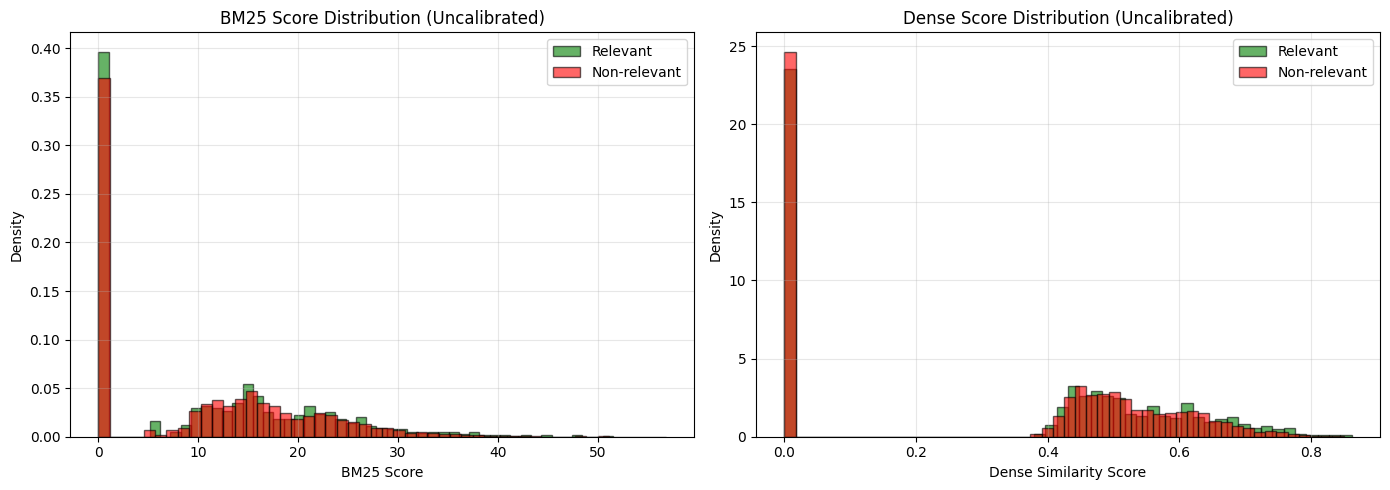


📊 Score Statistics:

BM25 (Sparse):
  Relevant: mean=11.0074, std=10.8964
  Non-relevant: mean=10.3756, std=10.2976

Dense:
  Relevant: mean=0.3262, std=0.2805
  Non-relevant: mean=0.3122, std=0.2737


In [37]:
plot_score_distributions(
    sparse_scores,
    dense_scores,
    labels,
    save_path=f"{save_dir}/score_distributions_uncalibrated.png"
)

conclusion : weak separation before the calibration